## Strategy Definition

Now that we have learned how to access and manipulate data in Quantopian, let's construct a data pipeline for our long-short equity strategy. In general, long-short equity strategies consist of modeling the relative value of assets with respect to each other, and placing bets on the sets of assets that we are confident will increase (long) and decrease (short) the most in value.  

Long-short equity strategies profit as the spread in returns between the sets of high and low value assets increases. The quality of a long-short equity strategy relies entirely on the quality of its underling ranking model. In this tutorial we will use a simple ranking schema for our strategy:  

**Strategy**: We will score assets based on two factors -> short-term to long-term average price ratio (mean reversion), and free cash flow to enterprise value ratio. Assets with a combined high score will be considered high value, while assets with a combined low score will be considered low value.

## Strategy Analysis

First, we will define our mean reversion factor using `SimpleMovingAverage` and `USEquityPricing.close`. We will try to capitalize on assets whose prices deviate, on the short term, from their long-term average. Assets with ratios greater than 1 should get low scores, while assets with ratios lower than 1 should get high scores:

In [1]:
# Pipeline imports
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import SimpleMovingAverage

# Mean Reversion Factor
sma60 = SimpleMovingAverage(
    inputs=[USEquityPricing.close],
    window_length=60
)
sma5 = SimpleMovingAverage(
    inputs=[USEquityPricing.close],
    window_length=5
)

mean_reversion_factor = 1 - (sma5 / sma60)

To calculate our valuation ratio we can simply get the latest value for both free cash flow and enterprise value, and divide:

In [2]:
# Pipeline imports
from quantopian.pipeline.data import factset

# Free Cash Flow to Enterprise Value Factor
free_cf_to_entrpr_val_factor = (
    factset.Fundamentals.free_cf_fcfe_qf.latest /
    factset.Fundamentals.entrpr_val_qf.latest
)

Let's build a Pipeline definition using these factors, along with the trading universe we created in the previous lesson. We will combine both factors by adding their z-scores:

In [3]:
# Pipeline imports
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import factset
from quantopian.pipeline.factors import (
    AverageDollarVolume,
    SimpleMovingAverage,
)

# Pipeline definition
def make_pipeline():
    # Universe Selection
    mcap_filter = factset.Fundamentals.mkt_val.latest > 500000000
    adv_filter = AverageDollarVolume(window_length=200) > 2500000
    price_filter = USEquityPricing.close.latest > 5

    universe = mcap_filter & adv_filter & price_filter

    # Mean Reversion Factor
    sma60 = SimpleMovingAverage(
        inputs=[USEquityPricing.close],
        window_length=60
    )
    sma5 = SimpleMovingAverage(
        inputs=[USEquityPricing.close],
        window_length=5
    )

    mean_reversion_factor = 1 - (sma5 / sma60)

    # Free Cash Flow to Enterprise Value Factor
    free_cf_to_entrpr_val_factor = (
        factset.Fundamentals.free_cf_fcfe_qf.latest /
        factset.Fundamentals.entrpr_val_qf.latest
    )

    alpha = (
        mean_reversion_factor.zscore(mask=universe) +
        free_cf_to_entrpr_val_factor.zscore(mask=universe)
    )

    return Pipeline(
        columns={
            'alpha': alpha,
        },
        screen=alpha.notnull()
    )

Notice we passed our universe as the `mask` parameter of `zscore`. This ensures that only assets in our universe are taken into account when computing z-scores. Also, our Pipeline definition now filters out assets for which no alpha value was calculated (`alpha.notnull()`).  

Next, let's execute our pipeline over the period of time we want to analyze. This will take ~1 minute.

In [4]:
# Import run_pipeline method
from quantopian.research import run_pipeline

# Specify a time range to evaluate
period_start = '2016-10-03'
period_end = '2017-10-03'

# Execute pipeline over evaluation period
pipeline_output = run_pipeline(
    make_pipeline(),
    start_date=period_start,
    end_date=period_end
)

In addition to our pipeline's data, we will need pricing data for all assets present in this period. We can easily get a list of these assets from our pipeline output's index, and pass that list to `prices` to get the pricing data we need:

In [5]:
# Import prices function
from quantopian.research import prices

# Get list of unique assets from the pipeline output
asset_list = pipeline_output.index.levels[1].unique()

# Query pricing data for all assets present during
# evaluation period
asset_prices = prices(
    asset_list,
    start=period_start,
    end=period_end
)

Now we can use Quantopian's open source factor analysis tool, [Alphalens](https://factset.quantopian.com/lectures/factor-analysis), to test the quality of our selection strategy. First, let's combine our factor and pricing data using `get_clean_factor_and_forward_returns`. This function classifies our factor data into quantiles and computes forward returns for each security for multiple holding periods. We will separate our factor data into 2 quantiles (the top and bottom half), and use 1, 5 and 10 day holding periods:

In [6]:
# Import Alphalens
import alphalens as al

# Get asset forward returns and quantile classification
# based on sentiment scores
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=pipeline_output['alpha'],
    prices=asset_prices,
    quantiles=2,
    periods=(1,5,10),
)

# Display first 5 rows
factor_data.head(5)

Dropped 4.2% entries from factor data: 4.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


1D        5D       10D  \
date                      asset                                             
2016-10-03 00:00:00+00:00 Equity(2 [ARNC])   0.006897  0.037183 -0.132938   
                          Equity(24 [AAPL])  0.004441  0.031467  0.044881   
                          Equity(31 [ABAX])  0.004126  0.035496  0.008173   
                          Equity(39 [DDC])  -0.051478 -0.044280 -0.035664   
                          Equity(52 [ABM])  -0.017141 -0.027918 -0.051449   

                                               factor  factor_quantile  
date                      asset                                         
2016-10-03 00:00:00+00:00 Equity(2 [ARNC])   0.415877                2  
                          Equity(24 [AAPL]) -0.548061                1  
                          Equity(31 [ABAX]) -0.052883                1  
                          Equity(39 [DDC])  -2.006637                1  
                          Equity(52 [ABM])  -0.553338                1

Having our data in this format allows us to use several of Alphalens's analysis and plotting tools. Let's start by looking at the mean returns by quantile over the entire period. Because our goal is to build a long-short strategy, we want to see the lower quantile (1) have negative returns and the upper quantile(2) have positive returns:

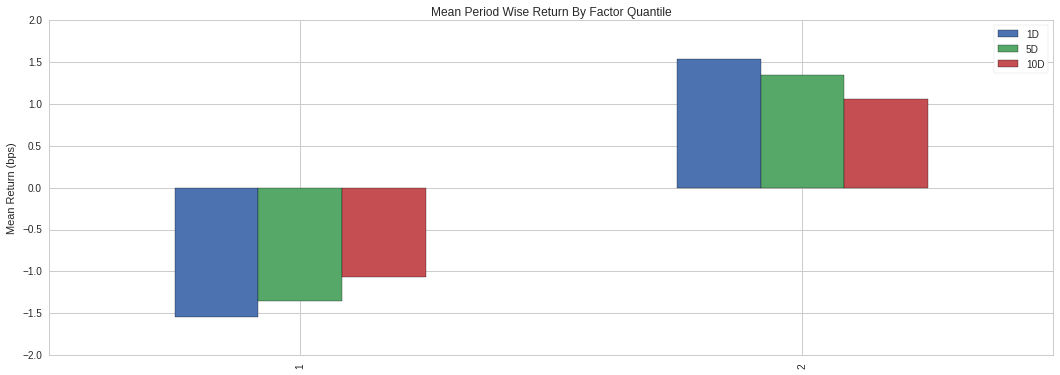

In [7]:
# Calculate mean return by factor quantile
mean_return_by_q, std_err_by_q = al.performance.mean_return_by_quantile(factor_data)

# Plot mean returns by quantile and holding period
# over evaluation time range
al.plotting.plot_quantile_returns_bar(
    mean_return_by_q.apply(
        al.utils.rate_of_return,
        axis=0,
        args=('1D',)
    )
);

We can also plot the cumulative returns of a factor-weighted long-short portfolio with a 1 day holding period using the following code:

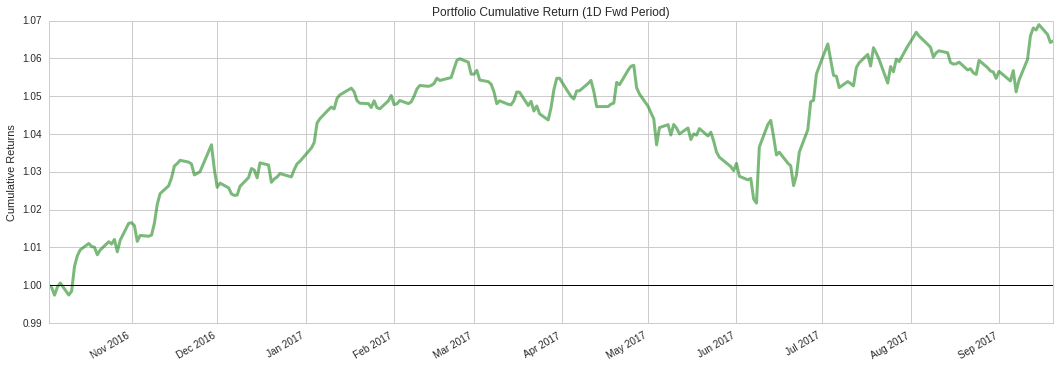

In [8]:
# Calculate factor-weighted long-short portfolio returns
ls_factor_returns = al.performance.factor_returns(factor_data)

# Plot cumulative returns for 1 day holding period
al.plotting.plot_cumulative_returns(ls_factor_returns['1D'], '1D');

The plot above shows a large drawdown period, and this analysis does not yet take into account transaction costs or market impact. It is not a very promising strategy. At this point we really should conduct a deeper analysis using Alphalens and then iterate on our strategy idea. But for the sake of this tutorial, let's continue with our strategy as it is.  

Having defined and tested a strategy, let's use it to build and test a long-short equity algorithm. The rest of the tutorial will cover the Algorithm API and will take place in the Interactive Development Environment (IDE).